In [1]:
import pickle 
import os
import pandas as pd
from tqdm import tqdm
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

from d2c.benchmark import D2CWrapper

from d2c.descriptors.loader import DataLoader

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [2]:
maxlags = 5 

We select only the files that we are interested in working with. This should be coherent with the files for which we have computed the descriptors.

In [3]:
data_root = '/home/jpalombarini/td2c/notebooks/paper_td2c/.data/'

to_dos = []
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01:
            continue

        if max_neighborhood_size != 2:
            continue

        to_dos.append(testing_file)

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

todos = {'5': to_dos_5_variables, '10': to_dos_10_variables, '25': to_dos_25_variables}

In [4]:
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/paper_td2c/.descriptors_ts_original_entropy/'
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(descriptors_root + testing_file)
        dfs.append(df)

descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

In [5]:
# # plot the precision recall curve against the threshold
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
# import matplotlib.pyplot as plt

# maxlags = 5

# td2c_rocs_process = {}
# td2c_precision_process = {}
# td2c_recall_process = {}
# td2c_f1_process = {}

# for testing_file in to_dos_5_variables:
#     print("Working on", testing_file)
#     gen_process_number = int(testing_file.split('_')[0][1:])
#     n_variables = int(testing_file.split('_')[1][1:])
#     max_neighborhood_size = int(testing_file.split('_')[2][2:])
#     noise_std = float(testing_file.split('_')[3][1:-4])


#     # split training and testing data
#     training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
#     X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
#     y_train = training_data['is_causal']

#     testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

#     model = BalancedRandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
#     # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

#     model.fit(X_train, y_train)

#     rocs = {}
#     precisions = {}
#     recalls = {}
#     f1s = {}
#     #load testing descriptors
#     test_df = testing_data
#     test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort to match the order of the model!

#     X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
#     y_test = test_df['is_causal']

#     y_pred_proba = model.predict_proba(X_test)[:,1]
#     y_pred = model.predict(X_test)

#     # Step 2: Calculate precision, recall, and thresholds
#     precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

#     # Step 3: Plot the precision-recall curve
#     plt.figure(figsize=(10, 6))
#     plt.plot(thresholds, precision[:-1], label='Precision')
#     plt.plot(thresholds, recall[:-1], label='Recall')
#     plt.xlabel('Threshold')
#     plt.ylabel('Precision/Recall')
#     plt.title('Precision-Recall vs Threshold')
#     plt.legend()
#     plt.grid()
#     plt.show()


In [6]:
# from sklearn.metrics import roc_auc_score
# maxlags = 5
# descriptors_root = './descriptors_ts_original_entropy/'
# data_root = '../data/'

# training_set_full = []
# for testing_file in to_dos_5_variables:
#     gen_process_number = int(testing_file.split('_')[0][1:])
#     n_variables = int(testing_file.split('_')[1][1:])
#     max_neighborhood_size = int(testing_file.split('_')[2][2:])
#     noise_std = float(testing_file.split('_')[3][1:-4])

#     dataloader = DataLoader(n_variables = n_variables,
#                 maxlags = maxlags)
#     dataloader.from_pickle(data_root+testing_file)
#     true_causal_dfs = dataloader.get_true_causal_dfs()

#     for i in range(40):

#         test_df = pd.read_csv(descriptors_root+testing_file+'_'+str(i)+'.csv', index_col=0)
#         test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort to match the order of the model!
#         test_df['is_causal'] = true_causal_dfs[i]['is_causal']
#         test_df['process_id'] = gen_process_number
#         test_df['graph_id'] = i
#         test_df['n_variables'] = n_variables
#         test_df['max_neighborhood_size'] = max_neighborhood_size
#         test_df['noise_std'] = noise_std

#         training_set_full.append(test_df)

# training_set_full = pd.concat(training_set_full, axis=0).reset_index(drop=True)



In [7]:

for n_vars, todo in todos.items():
    td2c_rocs_process = {}
    td2c_precision_process = {}
    td2c_recall_process = {}
    td2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rocs_process[gen_process_number] = rocs
        td2c_precision_process[gen_process_number] = precisions
        td2c_recall_process[gen_process_number] = recalls
        td2c_f1_process[gen_process_number] = f1s

    # pickle everything
    with open(f'journal_results_t2dc_N{n_vars}.pkl', 'wb') as f:
        everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process)
        pickle.dump(everything, f)

  0%|          | 0/3 [00:00<?, ?it/s]/home/jpalombarini/td2c/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv/lib/py

# TD2C CMIKNN

In [8]:
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/paper_td2c/.descriptors_ts_cmiknn_entropy/'
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(descriptors_root + testing_file)
        dfs.append(df)

descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

In [9]:

for n_vars, todo in todos.items():
    td2c_rocs_process = {}
    td2c_precision_process = {}
    td2c_recall_process = {}
    td2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rocs_process[gen_process_number] = rocs
        td2c_precision_process[gen_process_number] = precisions
        td2c_recall_process[gen_process_number] = recalls
        td2c_f1_process[gen_process_number] = f1s

    # pickle everything
    with open(f'journal_results_t2dc_cmiknn_N{n_vars}.pkl', 'wb') as f:
        everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process)
        pickle.dump(everything, f)

  0%|          | 0/3 [00:00<?, ?it/s]/home/jpalombarini/td2c/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv/lib/py

In [10]:
td2c_rocs_process

{}

In [11]:
# # load 
# with open('journal_results_t2dc_N5.pkl', 'rb') as f:
#     td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process = pickle.load(f)

In [12]:
# mix_td2c = pd.concat([pd.DataFrame(td2c_rocs_process).mean(),pd.DataFrame(td2c_precision_process).mean(),pd.DataFrame(td2c_recall_process).mean(),pd.DataFrame(td2c_f1_process).mean()],axis=1)
# mix_td2c.columns = ['roc','precision','recall','f1']
# #index name 'generative process'
# mix_td2c.index.name = 'generative process'
# mix_td2c

In [13]:
# mix_td2c = pd.concat([pd.DataFrame(td2c_rocs_process).mean(),pd.DataFrame(td2c_precision_process).mean(),pd.DataFrame(td2c_recall_process).mean(),pd.DataFrame(td2c_f1_process).mean()],axis=1)
# mix_td2c.columns = ['roc','precision','recall','f1']
# #index name 'generative process'
# mix_td2c.index.name = 'generative process'
# mix_td2c

In [14]:
# mix_td2c = pd.concat([pd.DataFrame(td2c_rocs_process).mean(),pd.DataFrame(td2c_precision_process).mean(),pd.DataFrame(td2c_recall_process).mean(),pd.DataFrame(td2c_f1_process).mean()],axis=1)
# mix_td2c.columns = ['roc','precision','recall','f1']
# #index name 'generative process'
# mix_td2c.index.name = 'generative process'
# mix_td2c

In [15]:
# mix_pcmci = pd.concat([pd.DataFrame(pcmci_rocs_process).mean(),pd.DataFrame(pcmci_precision_process).mean(),pd.DataFrame(pcmci_recall_process).mean(),pd.DataFrame(pcmci_f1_process).mean()],axis=1)
# mix_pcmci.columns = ['roc','precision','recall','f1']
# #index name 'generative process'
# mix_pcmci.index.name = 'generative process'
# mix_pcmci

# Granger

In [28]:
#ETA 8 min

from d2c.benchmark.granger import Granger
# suppress Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for n_vars, todo in todos.items():

        granger_rocs_process = {}
        granger_precision_process = {}
        granger_recall_process = {}
        granger_f1_process = {}

        for testing_file in tqdm(todo):
                gen_process_number = int(testing_file.split('_')[0][1:])
                n_variables = int(testing_file.split('_')[1][1:])
                max_neighborhood_size = int(testing_file.split('_')[2][2:])
                noise_std = float(testing_file.split('_')[3][1:-4])

                # load original data for truth values
                dataloader = DataLoader(n_variables = n_variables,
                                maxlags = maxlags)
                dataloader.from_pickle(data_root+testing_file)
                observations = dataloader.get_original_observations()
                true_causal_dfs = dataloader.get_true_causal_dfs()


                granger = Granger(ts_list=observations, maxlags=maxlags, n_jobs=40)
                granger.run()
                causal_dfs_granger = granger.get_causal_dfs()
                rocs = {}
                precisions = {}
                recalls = {}
                f1s = {}
                for i in range(40):

                        y_pred = causal_dfs_granger[i]['is_causal'].astype(int)
                        y_pred_proba = 1 - causal_dfs_granger[i]['p_value']
                        y_test = true_causal_dfs[i]['is_causal'].astype(int)

                        roc = roc_auc_score(y_test, y_pred_proba)
                        precision = precision_score(y_test, y_pred, zero_division=0)
                        recall = recall_score(y_test, y_pred)
                        f1 = f1_score(y_test, y_pred)
                        
                        rocs[i] = roc
                        precisions[i] = precision
                        recalls[i] = recall
                        f1s[i] = f1

                granger_rocs_process[gen_process_number] = rocs
                granger_precision_process[gen_process_number] = precisions
                granger_recall_process[gen_process_number] = recalls
                granger_f1_process[gen_process_number] = f1s

        # pickle everything
        with open(f'journal_results_granger_N{n_vars}.pkl', 'wb') as f:
                everything = (granger_rocs_process, granger_precision_process, granger_recall_process, granger_f1_process)
                pickle.dump(everything, f)

100%|██████████| 3/3 [00:07<00:00,  2.34s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [29]:
# pickle everything
with open('journal_results_granger_N25.pkl', 'wb') as f:
    everything = (granger_rocs_process, granger_precision_process, granger_recall_process, granger_f1_process)
    pickle.dump(everything, f)

In [30]:
#ETA 50 min 

from d2c.benchmark.pcmci import PCMCI

for n_vars, todo in todos.items():

        pcmci_rocs_process = {}
        pcmci_precision_process = {}
        pcmci_recall_process = {}
        pcmci_f1_process = {}

        for testing_file in tqdm(todo):
                gen_process_number = int(testing_file.split('_')[0][1:])
                n_variables = int(testing_file.split('_')[1][1:])
                max_neighborhood_size = int(testing_file.split('_')[2][2:])
                noise_std = float(testing_file.split('_')[3][1:-4])

                # load original data for truth values
                dataloader = DataLoader(n_variables = n_variables,
                                maxlags = maxlags)
                dataloader.from_pickle(data_root+testing_file)
                observations = dataloader.get_original_observations()
                true_causal_dfs = dataloader.get_true_causal_dfs()


                pcmci = PCMCI(ts_list=observations, maxlags=maxlags, n_jobs=40, ci="ParCorr")
                pcmci.run()
                causal_dfs_pcmci = pcmci.get_causal_dfs()
                rocs = {}
                precisions = {}
                recalls = {}
                f1s = {}
                for i in range(40):

                        y_pred = causal_dfs_pcmci[i]['is_causal'].astype(int)
                        y_pred_proba = 1 - causal_dfs_pcmci[i]['p_value']
                        y_test = true_causal_dfs[i]['is_causal'].astype(int)

                        roc = roc_auc_score(y_test, y_pred_proba)
                        precision = precision_score(y_test, y_pred)
                        recall = recall_score(y_test, y_pred)
                        f1 = f1_score(y_test, y_pred)
                        
                        rocs[i] = roc
                        precisions[i] = precision
                        recalls[i] = recall
                        f1s[i] = f1

                pcmci_rocs_process[gen_process_number] = rocs
                pcmci_precision_process[gen_process_number] = precisions
                pcmci_recall_process[gen_process_number] = recalls
                pcmci_f1_process[gen_process_number] = f1s

        # pickle everything
        with open(f'journal_results_pcmci_N{n_vars}.pkl', 'wb') as f:
                everything = (pcmci_rocs_process, pcmci_precision_process, pcmci_recall_process, pcmci_f1_process)
                pickle.dump(everything, f)

/home/jpalombarini/td2c/myenv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jpalombarini/td2c/myenv/lib/python3.7/site-packages/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'gpytorch'
  warnings.warn(str(e))
100%|██████████| 3/3 [00:07<00:00,  2.56s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [ ]:
# mix_pcmci = pd.concat([pd.DataFrame(pcmci_rocs_process).mean(),pd.DataFrame(pcmci_precision_process).mean(),pd.DataFrame(pcmci_recall_process).mean(),pd.DataFrame(pcmci_f1_process).mean()],axis=1)
# mix_pcmci.columns = ['roc','precision','recall','f1']
# #index name 'generative process'
# mix_pcmci.index.name = 'generative process'
# mix_pcmci

In [ ]:
# ! conda install -y seaborn

In [ ]:
# # boxplot mix_pcmci and mix_td2c
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# sns.boxplot(data=mix_pcmci, ax=ax[0, 0])
# ax[0, 0].set_title('PCMCI')
# ax[0, 0].set_ylabel('Score')
# ax[0, 0].set_xlabel('Metric')

# sns.boxplot(data=mix_td2c, ax=ax[0, 1])
# ax[0, 1].set_title('TD2C')
# ax[0, 1].set_ylabel('Score')
# ax[0, 1].set_xlabel('Metric')



# Dynotears

In [31]:
from d2c.benchmark.dynotears import DYNOTEARS
N_JOBS = 40

for n_vars, todo in todos.items():

        dyno_rocs_process = {}
        dyno_precision_process = {}
        dyno_recall_process = {}
        dyno_f1_process = {}

        for testing_file in tqdm(todo):
                gen_process_number = int(testing_file.split('_')[0][1:])
                n_variables = int(testing_file.split('_')[1][1:])
                max_neighborhood_size = int(testing_file.split('_')[2][2:])
                noise_std = float(testing_file.split('_')[3][1:-4])

                # load original data for truth values
                dataloader = DataLoader(n_variables = n_variables,
                                maxlags = maxlags)
                dataloader.from_pickle(data_root+testing_file)
                observations = dataloader.get_original_observations()
                true_causal_dfs = dataloader.get_true_causal_dfs()

                dynotears = DYNOTEARS(ts_list=observations, maxlags=maxlags, n_jobs=N_JOBS)
                dynotears.run()
                causal_dfs_dynotears = dynotears.get_causal_dfs()

                rocs = {}
                precisions = {}
                recalls = {}
                f1s = {}
                for i in range(40):

                        y_pred = causal_dfs_dynotears[i]['is_causal'].astype(int)
                        y_pred_proba = 1 - causal_dfs_dynotears[i]['p_value']
                        y_test = true_causal_dfs[i]['is_causal'].astype(int)

                        roc = None
                        precision = precision_score(y_test, y_pred, zero_division=0)
                        recall = recall_score(y_test, y_pred)
                        f1 = f1_score(y_test, y_pred)
                        
                        rocs[i] = roc
                        precisions[i] = precision
                        recalls[i] = recall
                        f1s[i] = f1

                dyno_rocs_process[gen_process_number] = rocs
                dyno_precision_process[gen_process_number] = precisions
                dyno_recall_process[gen_process_number] = recalls
                dyno_f1_process[gen_process_number] = f1s

        # pickle everything
        with open(f'journal_results_dyno_N{n_vars}.pkl', 'wb') as f:
                everything = (dyno_rocs_process, dyno_precision_process, dyno_recall_process, dyno_f1_process)
                pickle.dump(everything, f)

 67%|██████▋   | 2/3 [00:14<00:06,  6.56s/it]/home/jpalombarini/td2c/myenv/lib/python3.7/site-packages/causalnex/structure/dynotears.py:428: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * _h_value * _h_value + alpha * _h_value + l1_penalty
/home/jpalombarini/td2c/myenv/lib/python3.7/site-packages/causalnex/structure/dynotears.py:450: RuntimeWarning: overflow encountered in multiply
  + (rho * (np.trace(e_mat) - d_vars) + alpha) * e_mat.T * _w_mat * 2
/home/jpalombarini/td2c/myenv/lib/python3.7/site-packages/causalnex/structure/dynotears.py:450: RuntimeWarning: invalid value encountered in multiply
  + (rho * (np.trace(e_mat) - d_vars) + alpha) * e_mat.T * _w_mat * 2
100%|██████████| 3/3 [00:27<00:00,  9.18s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [ ]:
# mix_dyno = pd.concat([pd.DataFrame(dyno_rocs_process).mean(),pd.DataFrame(dyno_precision_process).mean(),pd.DataFrame(dyno_recall_process).mean(),pd.DataFrame(dyno_f1_process).mean()],axis=1)
# mix_dyno.columns = ['roc','precision','recall','f1']
# #index name 'generative process'
# mix_dyno.index.name = 'generative process'
# mix_dyno

In [32]:
import os
N_JOBS = 40
from d2c.benchmark.varlingam import VARLiNGAM

os.environ['MKL_NUM_THREADS'] = '1'  # Limit to 4 threads
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'  # Limit to 4 threads
os.environ['OMP_NUM_THREADS'] = '1'

# def complete_causal_df(causal_df, n_variables, maxlags):
#     causal_df = causal_df.copy()
#     all_pairs = [(from_, to) for from_ in range(n_variables,n_variables * (maxlags + 1)) for to in range(n_variables)]
    
#     existing_pairs = set(zip(causal_df['from'], causal_df['to']))
#     missing_pairs = [(from_, to) for from_, to in all_pairs if (from_, to) not in existing_pairs]
    
#     # Create all missing rows at once if there are any missing pairs
#     if missing_pairs:
#         missing_rows = pd.DataFrame(missing_pairs, columns=['from', 'to'])
#         missing_rows['effect'] = 0.0
#         missing_rows['p-value'] = None
#         missing_rows['probability'] = 0.0
#         missing_rows['is_causal'] = False
#         causal_df = pd.concat([causal_df, missing_rows], ignore_index=True)
    
#     return causal_df.sort_values(by=['from', 'to']).reset_index(drop=True)

for n_vars, todo in todos.items():
        
        if n_vars != '25':
                continue


        varlingam_rocs_process = {}
        varlingam_precision_process = {}
        varlingam_recall_process = {}
        varlingam_f1_process = {}

        for testing_file in tqdm(todo):
                gen_process_number = int(testing_file.split('_')[0][1:])
                n_variables = int(testing_file.split('_')[1][1:])
                max_neighborhood_size = int(testing_file.split('_')[2][2:])
                noise_std = float(testing_file.split('_')[3][1:-4])

                # load original data for truth values
                dataloader = DataLoader(n_variables = n_variables,
                                maxlags = maxlags)
                dataloader.from_pickle(data_root+testing_file)
                observations = dataloader.get_original_observations()
                true_causal_dfs = dataloader.get_true_causal_dfs()

                varlingam = VARLiNGAM(ts_list=observations, maxlags=maxlags, n_jobs=N_JOBS)
                varlingam.run()
                causal_dfs_varlingam = varlingam.get_causal_dfs()

                # causal_dfs_varlingam = [complete_causal_df(causal_df, n_variables,maxlags) for causal_df in causal_dfs_varlingam.values()]

                rocs = {}
                precisions = {}
                recalls = {}
                f1s = {}
                for i in range(40):

                        y_pred = causal_dfs_varlingam[i]['is_causal'].astype(int)
                        y_pred_proba = causal_dfs_varlingam[i]['probability']
                        y_test = true_causal_dfs[i]['is_causal'].astype(int)

                        roc = roc_auc_score(y_test, y_pred_proba)
                        precision = precision_score(y_test, y_pred)
                        recall = recall_score(y_test, y_pred)
                        f1 = f1_score(y_test, y_pred)
                        
                        rocs[i] = roc
                        precisions[i] = precision
                        recalls[i] = recall
                        f1s[i] = f1

                varlingam_rocs_process[gen_process_number] = rocs
                varlingam_precision_process[gen_process_number] = precisions
                varlingam_recall_process[gen_process_number] = recalls
                varlingam_f1_process[gen_process_number] = f1s

        # pickle everything
        with open(f'journal_results_varlingam_N{n_vars}.pkl', 'wb') as f:
                everything = (varlingam_rocs_process, varlingam_precision_process, varlingam_recall_process, varlingam_f1_process)
                pickle.dump(everything, f)

0it [00:00, ?it/s]


In [42]:
mix_varlingam = pd.concat([pd.DataFrame(varlingam_rocs_process).mean(),pd.DataFrame(varlingam_precision_process).mean(),pd.DataFrame(varlingam_recall_process).mean(),pd.DataFrame(varlingam_f1_process).mean()],axis=1)
mix_varlingam.columns = ['roc','precision','recall','f1']
#index name 'generative process'
mix_varlingam.index.name = 'generative process'
mix_varlingam

,roc,precision,recall,f1
generative process,,,,


In [43]:
# pickle everything
with open('journal_results_N5.pkl', 'wb') as f:
    everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process, pcmci_rocs_process, pcmci_precision_process, pcmci_recall_process, pcmci_f1_process, dyno_rocs_process, dyno_precision_process, dyno_recall_process, dyno_f1_process, varlingam_rocs_process, varlingam_precision_process, varlingam_recall_process, varlingam_f1_process)
    pickle.dump(everything, f)

In [44]:
# load 
import pickle
with open('journal_results_N5.pkl', 'rb') as f:
    td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process, pcmci_rocs_process, pcmci_precision_process, pcmci_recall_process, pcmci_f1_process, dyno_rocs_process, dyno_precision_process, dyno_recall_process, dyno_f1_process, varlingam_rocs_process, varlingam_precision_process, varlingam_recall_process, varlingam_f1_process = pickle.load(f)

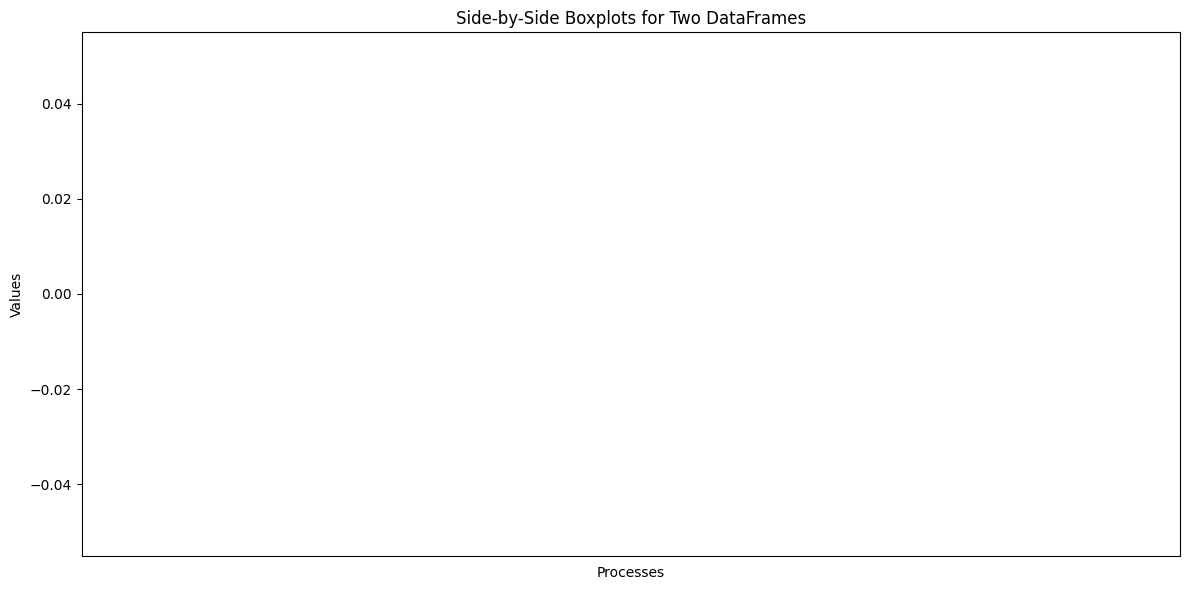

In [36]:
import matplotlib.pyplot as plt

df1 = pd.DataFrame(td2c_rocs_process)
df2 = pd.DataFrame(pcmci_rocs_process)
df3 = pd.DataFrame(varlingam_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C')
    labels.append(f'{col} PCMCI')
    labels.append(f'{col} VARLiNGAM')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for Two DataFrames')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

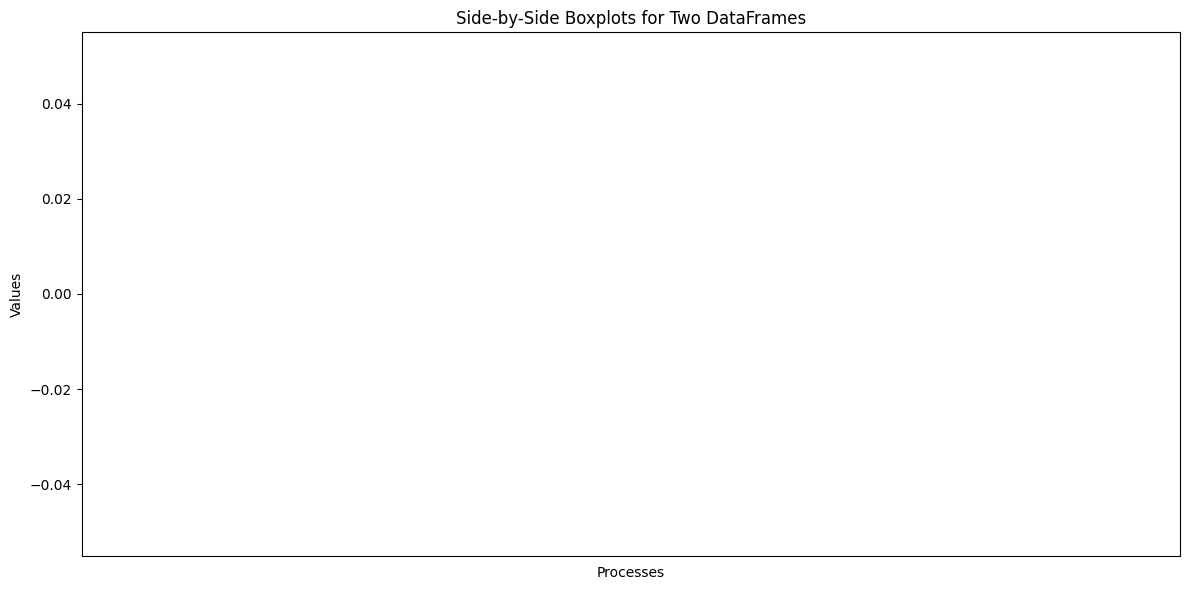

In [37]:
import matplotlib.pyplot as plt

df1 = pd.DataFrame(td2c_f1_process)
df2 = pd.DataFrame(pcmci_f1_process)
df3 = pd.DataFrame(varlingam_f1_process)
df4 = pd.DataFrame(dyno_f1_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} td2c')
    labels.append(f'{col} pcmci')
    labels.append(f'{col} varlingam')
    labels.append(f'{col} dyno')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 4])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for Two DataFrames')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

In [38]:
df1.columns

Index([], dtype='object')

KeyError: 1

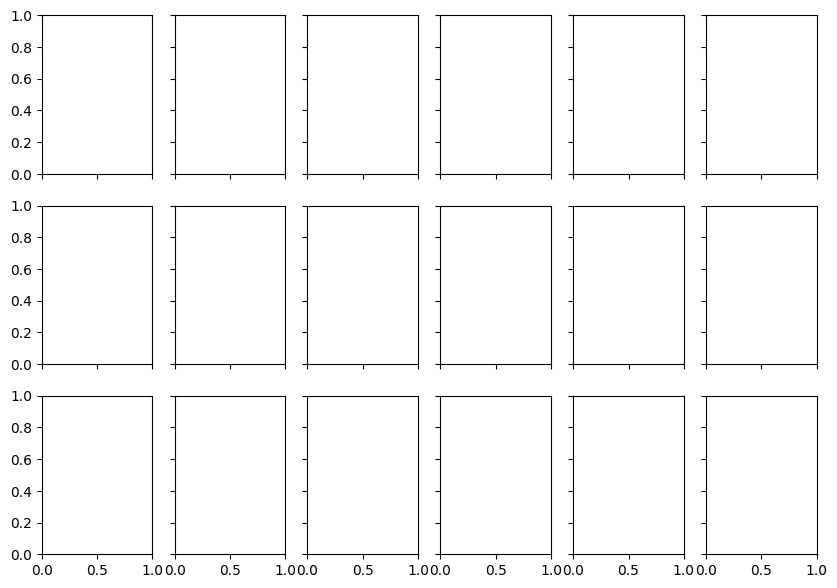

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming td2c_f1_process, pcmci_f1_process, varlingam_f1_process, and dyno_f1_process are defined

df1 = pd.DataFrame(td2c_f1_process)
df2 = pd.DataFrame(pcmci_f1_process)
df3 = pd.DataFrame(varlingam_f1_process)
df4 = pd.DataFrame(dyno_f1_process)

# Number of processes
num_processes = df1.shape[1]
fontsize = 7
# Plotting each process separately in a grid of 6 columns and 3 rows
fig, axes = plt.subplots(3, 6, figsize=(10, 7), sharex=True, sharey=True)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

for i, col in enumerate([1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]):
    combined_data = [df1[col], df2[col], df3[col], df4[col]]
    labels = [f'TD2C', f'PCMCI', f'VARLINGAM', f'DYNOTEARS']
    
    row, col_idx = divmod(i, 6)
    box = axes[row, col_idx].boxplot(combined_data, patch_artist=True)
    
    for patch, j in zip(box['boxes'], range(len(box['boxes']))):
        patch.set_facecolor(colors[j % 4])
    
    axes[row, col_idx].set_title(f'Process {col}')
    axes[row, col_idx].title.set_fontsize(fontsize)
    axes[row, col_idx].set_xticks(range(1, len(labels) + 1))
    axes[row, col_idx].set_xticklabels(labels, rotation=-90)
    axes[row, col_idx].tick_params(axis='x', labelsize=fontsize)
    if col_idx == 0:
        axes[row, col_idx].set_ylabel('F1 Score')
        axes[row, col_idx].yaxis.label.set_size(fontsize)
    # Add this line:
    axes[row, col_idx].grid(True)


# Remove any empty subplots if the number of processes is less than 18
if num_processes < 18:
    for i in range(num_processes, 18):
        row, col_idx = divmod(i, 6)
        fig.delaxes(axes[row, col_idx])

plt.tight_layout()
plt.savefig('f1_scores_N5.pdf', format='pdf')

plt.show()

#make vector image pdf


KeyError: 1

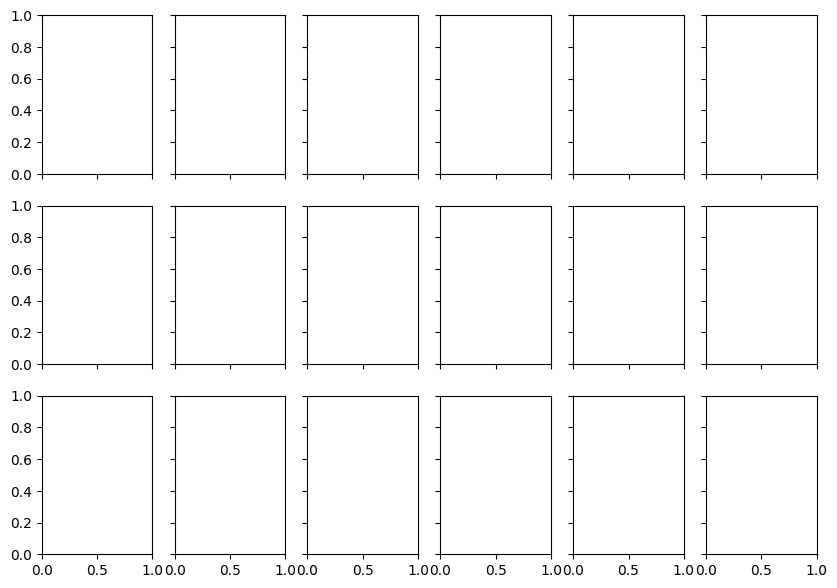

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming td2c_f1_process, pcmci_f1_process, varlingam_f1_process, and dyno_f1_process are defined

df1 = pd.DataFrame(td2c_rocs_process)
df2 = pd.DataFrame(pcmci_rocs_process)
df3 = pd.DataFrame(varlingam_rocs_process)

# Number of processes
num_processes = df1.shape[1]
fontsize = 7
# Plotting each process separately in a grid of 6 columns and 3 rows
fig, axes = plt.subplots(3, 6, figsize=(10, 7), sharex=True, sharey=True)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

for i, col in enumerate([1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]):
    combined_data = [df1[col], df2[col], df3[col]]
    labels = [f'TD2C', f'PCMCI', f'VARLINGAM']
    
    row, col_idx = divmod(i, 6)
    box = axes[row, col_idx].boxplot(combined_data, patch_artist=True)
    
    for patch, j in zip(box['boxes'], range(len(box['boxes']))):
        patch.set_facecolor(colors[j % 3])
    
    axes[row, col_idx].set_title(f'Process {col}')
    axes[row, col_idx].title.set_fontsize(fontsize)
    axes[row, col_idx].set_xticks(range(1, len(labels) + 1))
    axes[row, col_idx].set_xticklabels(labels, rotation=-90)
    axes[row, col_idx].tick_params(axis='x', labelsize=fontsize)
    if col_idx == 0:
        axes[row, col_idx].set_ylabel('ROC AUC')
        axes[row, col_idx].yaxis.label.set_size(fontsize)
    # Add this line:
    axes[row, col_idx].grid(True)


# Remove any empty subplots if the number of processes is less than 18
if num_processes < 18:
    for i in range(num_processes, 18):
        row, col_idx = divmod(i, 6)
        fig.delaxes(axes[row, col_idx])

plt.tight_layout()
plt.savefig('roc_scores_N5.pdf', format='pdf')

plt.show()

#make vector image pdf


In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming td2c_f1_process, pcmci_f1_process, varlingam_f1_process, and dyno_f1_process are defined

df1 = pd.DataFrame(td2c_f1_process)
df2 = pd.DataFrame(pcmci_f1_process)
df3 = pd.DataFrame(varlingam_f1_process)
df4 = pd.DataFrame(dyno_f1_process)

# Concatenate the data for each method across all processes
combined_td2c = pd.concat([df1[col] for col in df1.columns], ignore_index=True)
combined_pcmci = pd.concat([df2[col] for col in df2.columns], ignore_index=True)
combined_varlingam = pd.concat([df3[col] for col in df3.columns], ignore_index=True)
combined_dyno = pd.concat([df4[col] for col in df4.columns], ignore_index=True)

# Combine all methods into one DataFrame for plotting
combined_data = [combined_td2c, combined_pcmci, combined_varlingam, combined_dyno]
labels = ['TD2C', 'PCMCI', 'VARLINGAM', 'DYNOTEARS']

# Create a single boxplot
fig, ax = plt.subplots(figsize=(8, 6))
box = ax.boxplot(combined_data, patch_artist=True)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=-90, fontsize=10)
ax.set_ylabel('F1 Score', fontsize=10)
ax.set_title('Combined F1 Scores for All Processes - N=5', fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.savefig('combined_f1_scores_N5.pdf', format='pdf')

plt.show()


ValueError: No objects to concatenate

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming td2c_rocs_process, pcmci_rocs_process, and varlingam_rocs_process are defined

df1 = pd.DataFrame(td2c_rocs_process)
df2 = pd.DataFrame(pcmci_rocs_process)
df3 = pd.DataFrame(varlingam_rocs_process)

# Concatenate the data for each method across all processes
combined_td2c = pd.concat([df1[col] for col in df1.columns], ignore_index=True)
combined_pcmci = pd.concat([df2[col] for col in df2.columns], ignore_index=True)
combined_varlingam = pd.concat([df3[col] for col in df3.columns], ignore_index=True)

# Combine all methods into one DataFrame for plotting
combined_data = [combined_td2c, combined_pcmci, combined_varlingam]
labels = ['TD2C', 'PCMCI', 'VARLINGAM']

# Create a single boxplot
fig, ax = plt.subplots(figsize=(8, 6))
box = ax.boxplot(combined_data, patch_artist=True)

colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=-90, fontsize=10)
ax.set_ylabel('ROC AUC', fontsize=10)
ax.set_title('Combined ROC AUC Scores for All Processes - N=5', fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.savefig('combined_roc_scores_N5.pdf', format='pdf')

plt.show()


In [ ]:

from sklearn.metrics import roc_auc_score

rocs_process = {}
for process in descriptors_training['process_id'].unique():

    training_data = descriptors_training.loc[descriptors_training['process_id'] != process]
    X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
    y_train = training_data['is_causal']

    model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50)

    model.fit(X_train, y_train)

    rocs = {}
    for i in range(40):
        test_df = pd.read_csv(f'./d2c_benchmark/P{process}_N5_Nj2_n0.01.pkl'+'_'+str(i)+'.csv', index_col=0)
        test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True)

        X_test = test_df.drop(columns=['graph_id', 'edge_source', 'edge_dest', 'is_causal'])
        y_test = true_causal_dfs[i]['is_causal']


        y_pred = model.predict_proba(X_test)[:,1]

        roc = roc_auc_score(y_test, y_pred)

        rocs[i] = roc

    rocs_process[process] = rocs




In [ ]:
data_root = '../../data/new_data/'
destination_root = './'
destination = 'd2c_all_couples_MB5_full'
if not os.path.exists(destination_root+'/'+destination):
    os.makedirs(destination_root+'/'+destination)
maxlags = 5
# empty folder ../../data/new_benchmark/
for todo in [to_dos_10_variables]:
    for testing_file in tqdm(todo):
        if testing_file.endswith('.pkl'):
            gen_process_number = int(testing_file.split('_')[0][1:])
            n_variables = int(testing_file.split('_')[1][1:])
            max_neighborhood_size = int(testing_file.split('_')[2][2:])
            noise_std = float(testing_file.split('_')[3][1:-4])
                
            filename = f'{destination_root}/{destination}/P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'

            training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
            X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_train = training_data['is_causal']

            model = BalancedRandomForestClassifier(n_estimators=50, random_state=0, n_jobs=1, replacement=True, sampling_strategy='all')

            model.fit(X_train, y_train)

            dataloader = DataLoader(n_variables = n_variables,
                            maxlags = maxlags)
            dataloader.from_pickle(data_root+testing_file)
            observations = dataloader.get_original_observations()
            true_causal_dfs = dataloader.get_true_causal_dfs()

            d2cwrapper = D2CWrapper(ts_list=observations, n_variables=n_variables, model=model, maxlags=maxlags, n_jobs = 55, full=True)

            d2cwrapper.run()

            causal_df = d2cwrapper.get_causal_dfs()

            with open(filename, 'wb') as f:
                    pickle.dump((
                                causal_df, 
                                true_causal_dfs), f)     
    

25 vars

In [ ]:
data_root = '../../data/new_data/'
destination_root = '../../data/new_benchmark'
destination = 'd2c_all_couples_MB5_full'

if not os.path.exists(destination_root+'/'+destination):
    os.makedirs(destination_root+'/'+destination)
maxlags = 5
# empty folder ../../data/new_benchmark/

for todo in [to_dos_25_variables]:
    for testing_file in tqdm(todo):
        if testing_file.endswith('.pkl'):
            gen_process_number = int(testing_file.split('_')[0][1:])
            n_variables = int(testing_file.split('_')[1][1:])
            max_neighborhood_size = int(testing_file.split('_')[2][2:])
            noise_std = float(testing_file.split('_')[3][1:-4])
                
            filename = f'{destination_root}/{destination}/P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'

            training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
            X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_train = training_data['is_causal']

            model = BalancedRandomForestClassifier(n_estimators=50, random_state=0, n_jobs=1, replacement=True, sampling_strategy='all')

            model.fit(X_train, y_train)

            dataloader = DataLoader(n_variables = n_variables,
                            maxlags = maxlags)
            dataloader.from_pickle(data_root+testing_file)
            observations = dataloader.get_original_observations()
            true_causal_dfs = dataloader.get_true_causal_dfs()


            d2cwrapper = D2CWrapper(ts_list=observations, n_variables=n_variables, model=model, maxlags=maxlags, n_jobs = 55, full=True)

            d2cwrapper.run()

            causal_df = d2cwrapper.get_causal_dfs()

            with open(filename, 'wb') as f:
                    pickle.dump((
                                causal_df, 
                                true_causal_dfs), f)     
    

In [ ]:
# handle the two missing files separately
missing_files = ['P8_N25_Nj8_n0.005.pkl','P9_N25_Nj8_n0.005.pkl']

data_root = '../../data/new_data/'
destination_root = '../../data/new_benchmark'
destination = 'd2c_all_couples_MB5_full'

maxlags = 5
# empty folder ../../data/new_benchmark/


for testing_file in tqdm(missing_files):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
            
        filename = f'{destination_root}/{destination}/P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'

        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        model = BalancedRandomForestClassifier(n_estimators=50, random_state=0, n_jobs=1, replacement=True, sampling_strategy='all')

        model.fit(X_train, y_train)

        dataloader = DataLoader(n_variables = n_variables,
                        maxlags = maxlags)
        dataloader.from_pickle(data_root+testing_file)
        observations = dataloader.get_original_observations()
        true_causal_dfs = dataloader.get_true_causal_dfs()


        d2cwrapper = D2CWrapper(ts_list=observations, n_variables=n_variables, model=model, maxlags=maxlags, n_jobs = 55, full=True)

        d2cwrapper.run()

        causal_df = d2cwrapper.get_causal_dfs()

        with open(filename, 'wb') as f:
                pickle.dump((
                            causal_df, 
                            true_causal_dfs), f)     
    

50 variables is just too much

In [ ]:
# root = '../../data/new_data/'
# destination_root = '../../data/new_benchmark'
# destination = 'd2c_all_couples_MB5_full'

# if not os.path.exists(destination_root+'/'+destination):
#     os.makedirs(destination_root+'/'+destination)
# maxlags = 5
# # empty folder ../../data/new_benchmark/

# for todo in [to_dos_50_variables]:
#     for file in tqdm(todo):
#         if file.endswith('.pkl'):
#             gen_process_number = int(file.split('_')[0][1:])
#             n_variables = int(file.split('_')[1][1:])
#             max_neighborhood_size = int(file.split('_')[2][2:])
#             noise_std = float(file.split('_')[3][1:-4])
                
#             filename = f'{destination_root}/{destination}/P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'

#             training_data = data.loc[data['process_id'] != gen_process_number]
#             X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
#             y_train = training_data['is_causal']

#             model = BalancedRandomForestClassifier(n_estimators=50, random_state=0, n_jobs=1, replacement=True, sampling_strategy='all')

#             model.fit(X_train, y_train)

#             dataloader = DataLoader(n_variables = n_variables,
#                             maxlags = maxlags)
#             dataloader.from_pickle(root+file)
#             observations = dataloader.get_original_observations()
#             true_causal_dfs = dataloader.get_true_causal_dfs()


#             d2cwrapper = D2CWrapper(ts_list=observations, n_variables=n_variables, model=model, maxlags=maxlags, n_jobs = 55, full=True)

#             d2cwrapper.run()

#             causal_df = d2cwrapper.get_causal_dfs()

#             with open(filename, 'wb') as f:
#                     pickle.dump((
#                                 causal_df, 
#                                 true_causal_dfs), f)     
    